<a href="https://colab.research.google.com/github/justinetaylor/mids-w207-final-project/blob/yang_branch/clear_cut_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Cover Type Prediction
#### Team: Clear-Cut Solution: Kevin Martin, Yang Jing, Justine Schabel

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Libraries for reading, cleaning and plotting the dataa
import numpy as np 
import pandas as pd 
import csv
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import os
import re

# Libraries for models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression


In [2]:
#mount the drive for file storage
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/My Drive/W207-Final-Project')


## Data Engineering

### Load Data

In [4]:
# Read in training data 
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### Initial Data Exploration

First, we check the data attributes, quality and shape.

In [5]:
# Examine shape 
print(train_df.shape)

# Briefly examine feature attributes for the training data 
train_df.describe()

(15120, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [6]:
#check data types
train_df.dtypes

Id                                    int64
Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                      

In [7]:
train_df.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [8]:
# Collect numeric feature column names - so we can easily access these columns when modifying them 
num_cols = ['Elevation', 'Slope','Aspect',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

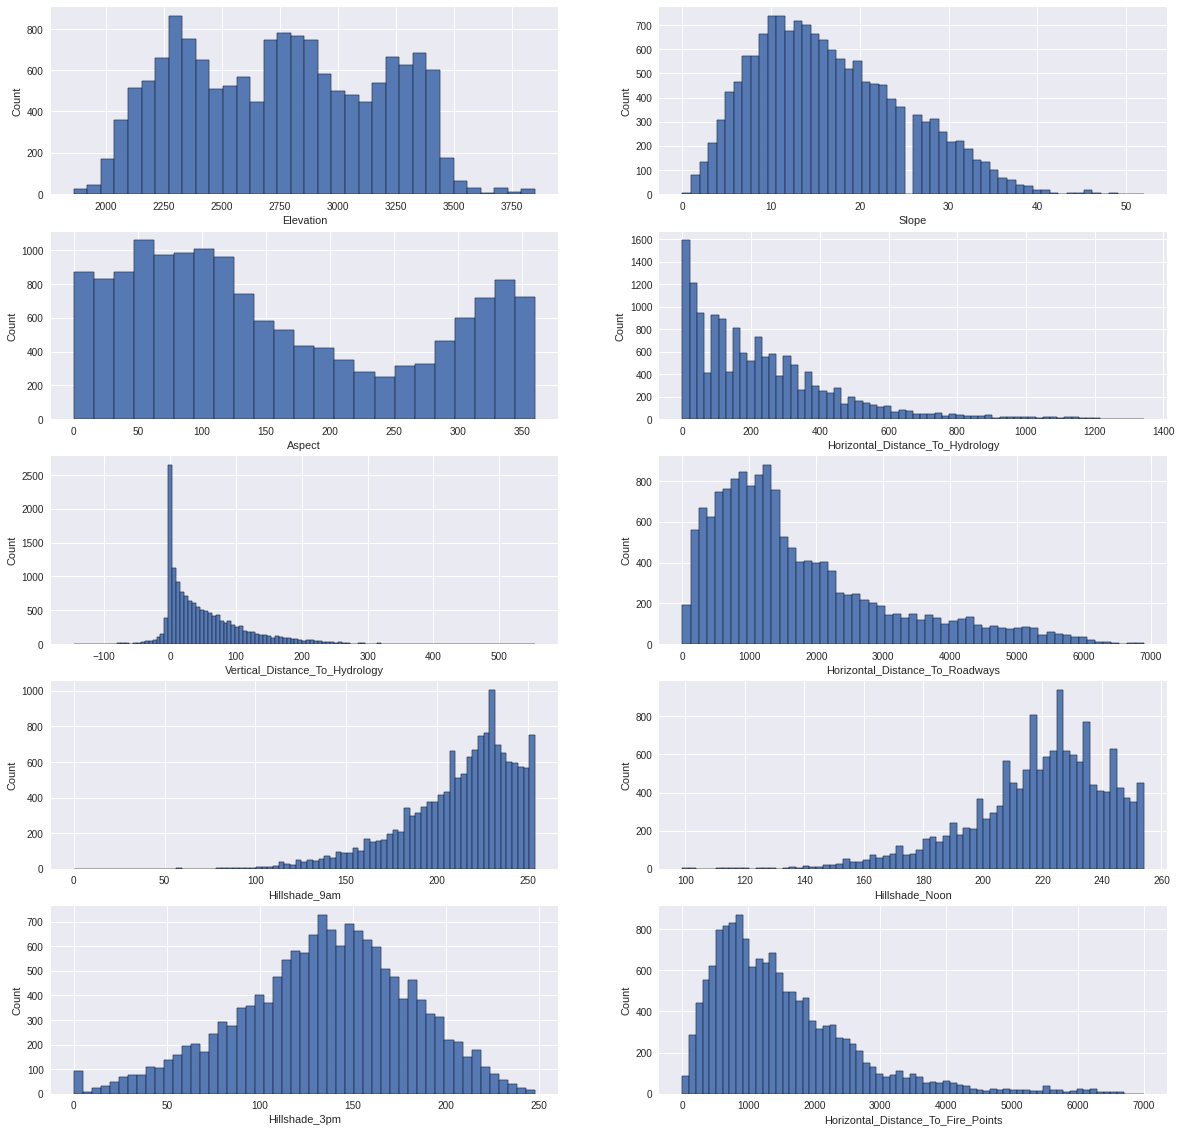

In [9]:
#visualize the distribution of numerical columns
col_ct = len(num_cols)
rows = col_ct//2
fig, axes = plt.subplots(rows,2,figsize=(20,20))
for i in range(col_ct):
  for j in range(2):
    col= train_df[num_cols[j+2*(i//2)]]
    sns.histplot(col, ax=axes[i//2][j])
    axes[i//2][j].grid()

Here we can see the distribution are skewed for a few variables, espcially in the "distance" related ones, such as "Horizontal_Diestance_To_Fire_points". A log-transformation may imporve the model performance. Also, there are zeros in these variables, we need to add 1 before performing the log transofrmation.

<Figure size 432x288 with 0 Axes>

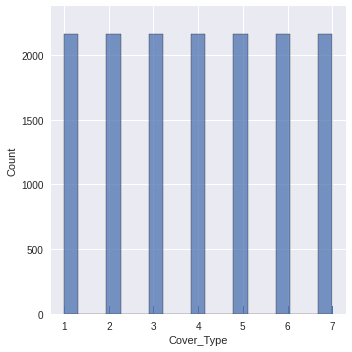

In [10]:
#visualize the distribution of labels, "Cover_Type"
plt.figure(figsize=(6,4))
sns.displot(train_df["Cover_Type"],rug=True)
plt.show()

Here we can see that the training data has a somewhat uniform distribution of covertype and this tells us that our data set is balanced. 

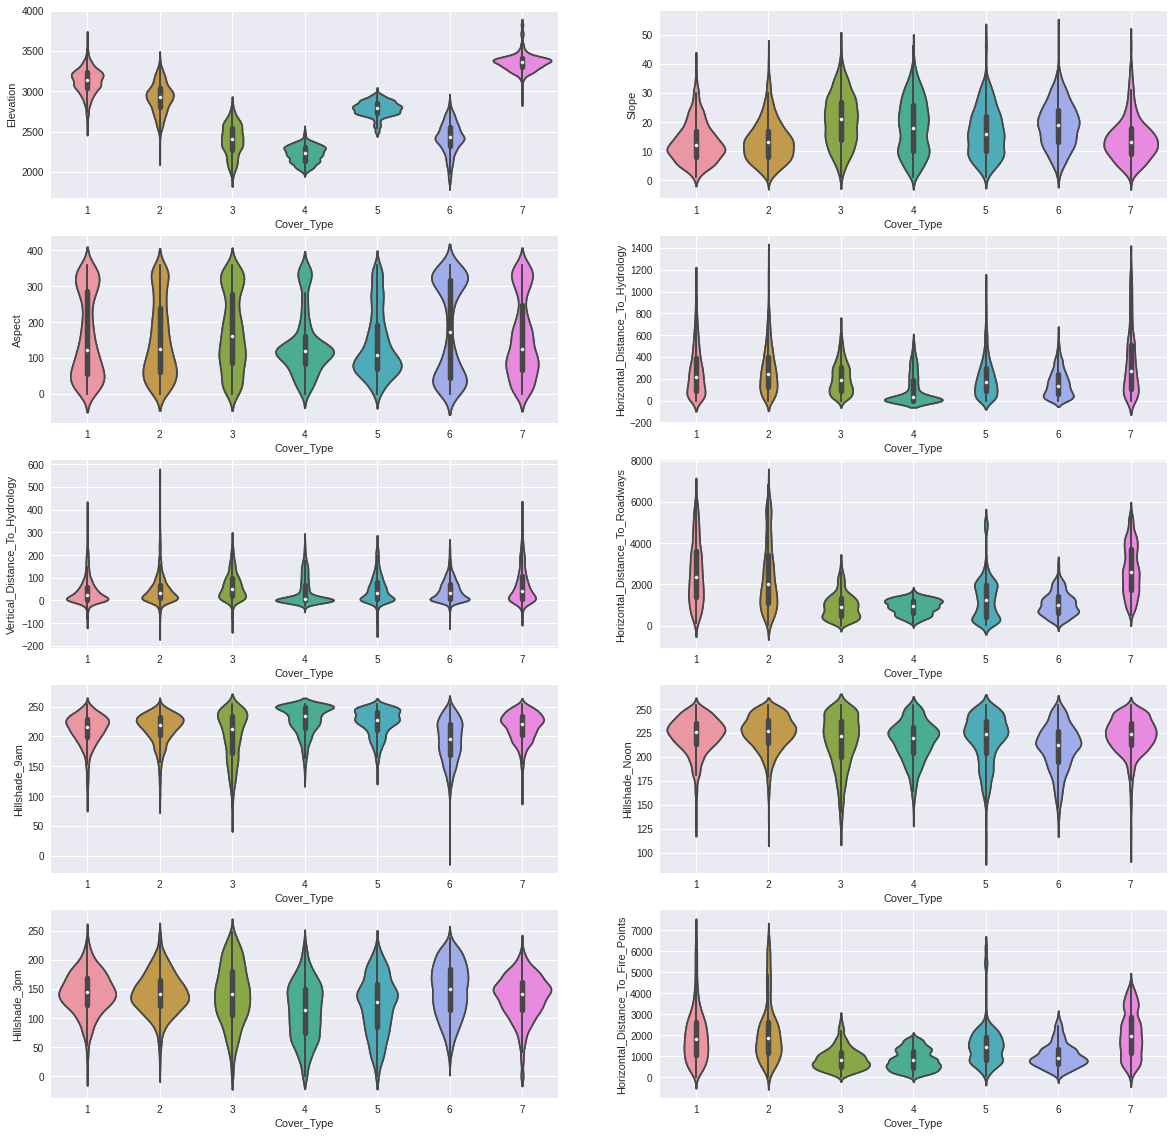

In [11]:
#visualize the distribution of numerical columns with Cover Type
fig, axes = plt.subplots(rows,2,figsize=(20,20))
for i in range(col_ct):
  for j in range(2):
    col= train_df[num_cols[j+2*(i//2)]]
    sns.violinplot(x=train_df['Cover_Type'], y= col, ax=axes[i//2][j])
    axes[i//2][j].grid()

First, we can see there is a relationship between the cover type and elevation. The difference in the other fetures by cover type seem less significant. Cover type 1 and 2 share a lot of similar features. We need to find a way to magnify the signal between the 2 cover types. 

We also see there is not much differences in the relationship between the cover type and Aspect. The Aspect is expressed in degrees, and 0 degree and 360 degree is the same thing but represented differently. This probably contributed to poor distinction among the lables. In feature engineering, we'll extract the sine and cosine values to normalize this feature.


In [12]:
# get NA values

print("There are {} NA values in the training data".format(train_df.isna().sum().sum()))
print("There are {} NA values in the test data".format(train_df.isna().sum().sum()))
    # `.isna()` returns a df with bools the first `.sum()` returns series, second is int 
print()
print("There are {} values in the training data".format(train_df.count()[0]))
print("There are {} values in the test data".format(test_df.count()[0]))

There are 0 NA values in the training data
There are 0 NA values in the test data

There are 15120 values in the training data
There are 565892 values in the test data


No null values in the dataset. Also noted the "aspect" variable has a value between 0 and 359. This is expressed in degrees, compared to "true north". Will conver this ino sine(EW) and cosine(NS) values. 

Now, we'll isolate and explore the distribution of soil types. 

In [13]:
# get a list of categorical column names
cat_cols = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40','Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4']

soil_cols = cat_cols.copy()
soil_cols.append("Cover_Type")
soil_df = train_df[soil_cols]

# Now we convert the soil type columns back into one column with values as the "soil type"
soil_df_unpivoted = soil_df.melt(id_vars="Cover_Type",var_name="soil_type",value_name="yes")
mask1 = soil_df_unpivoted["yes"] ==1 #only keep rows of where the "soil type" is "yes"
soil_df_unpivoted = soil_df_unpivoted[mask1]


In [14]:
#visualize cover type VS solil type in a pivot table. 
df1 = soil_df_unpivoted.groupby(["Cover_Type","soil_type"], as_index=False).count()
df1 = df1.pivot("Cover_Type","soil_type","yes")
df1


soil_type,Soil_Type1,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type2,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type3,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type4,Soil_Type40,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
Cover_Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,9.0,5.0,24.0,17.0,NaN,9.0,2.0,NaN,15.0,NaN,41.0,12.0,275.0,376.0,128.0,NaN,7.0,7.0,NaN,407.0,NaN,81.0,114.0,230.0,184.0,NaN,3.0,NaN,NaN,80.0,79.0,5.0,49.0,NaN,NaN,NaN,1.0,1062.0,181.0,917.0,NaN
2,NaN,81.0,67.0,203.0,84.0,NaN,14.0,7.0,16.0,13.0,3.0,55.0,NaN,54.0,149.0,72.0,1.0,19.0,5.0,6.0,554.0,12.0,144.0,97.0,255.0,184.0,12.0,1.0,2.0,NaN,7.0,3.0,20.0,3.0,NaN,7.0,1.0,9.0,1134.0,66.0,940.0,20.0
3,121.0,717.0,89.0,NaN,4.0,4.0,5.0,34.0,NaN,NaN,283.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.0,NaN,55.0,248.0,NaN,NaN,NaN,NaN,863.0,1297.0
4,139.0,170.0,24.0,NaN,NaN,128.0,40.0,350.0,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,799.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.0,NaN,39.0,244.0,NaN,NaN,NaN,NaN,NaN,2160.0
5,NaN,64.0,154.0,NaN,305.0,NaN,9.0,131.0,44.0,18.0,61.0,6.0,NaN,NaN,157.0,11.0,NaN,28.0,NaN,3.0,254.0,NaN,480.0,87.0,100.0,115.0,4.0,NaN,NaN,NaN,NaN,NaN,129.0,NaN,NaN,NaN,NaN,NaN,856.0,NaN,1304.0,NaN
6,95.0,1101.0,67.0,NaN,66.0,37.0,37.0,88.0,NaN,NaN,182.0,37.0,NaN,NaN,3.0,15.0,NaN,NaN,NaN,NaN,NaN,18.0,NaN,7.0,30.0,66.0,2.0,NaN,NaN,NaN,NaN,NaN,87.0,NaN,71.0,151.0,NaN,NaN,NaN,NaN,962.0,1198.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,16.0,72.0,31.0,NaN,NaN,3.0,NaN,76.0,NaN,20.0,27.0,70.0,67.0,4.0,98.0,8.0,34.0,641.0,575.0,7.0,407.0,NaN,NaN,NaN,NaN,545.0,252.0,1363.0,NaN


As we can see in the pivot table above, there are similar combinaiton of soil types for different "cover type". We'll combine the soil types that share same "cover types" to reduce dimensionality. Furhter, "cover type 1" and "cover type 2" , "cover type 3" and "cover type 6" share many overlapping features. To magnify the signal, we'll combine features as an extra featrue where there is a difference between the 2 pairs of cover types.

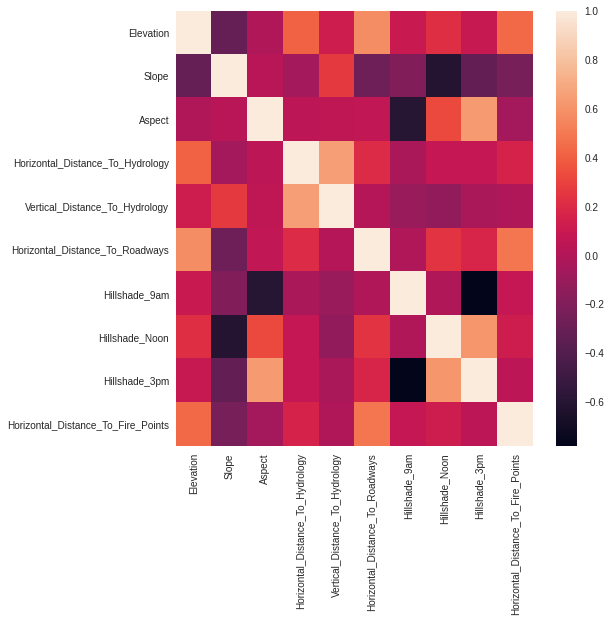

In [15]:
# Explore correlations between numerical features
train_corr=train_df[num_cols].corr()

#plot a heat map for correlations
ax = plt.figure(figsize=(8,8))
sns.heatmap(train_corr, xticklabels=train_corr.columns.values, yticklabels=train_corr.columns.values)
plt.show()

From the above, "Hillshade_9am" has strong correlation with "Hillshade_3pm" and "Aspect". We may drop this feature to avoid multi-collinearity.

In [16]:
# Rank correlations with "cover type"
train_corr1=train_df.corr()
train_corr1['Cover_Type'].abs().sort_values(ascending=False)[:31]

Cover_Type                            1.000000
Soil_Type38                           0.257810
Soil_Type39                           0.240384
Wilderness_Area1                      0.230117
Soil_Type29                           0.218564
Soil_Type40                           0.205851
Soil_Type22                           0.195993
Soil_Type23                           0.158762
Soil_Type32                           0.132312
Soil_Type12                           0.129985
Soil_Type10                           0.128972
Wilderness_Area3                      0.122146
Soil_Type35                           0.114327
Id                                    0.108363
Horizontal_Distance_To_Roadways       0.105662
Soil_Type24                           0.100797
Hillshade_Noon                        0.098905
Horizontal_Distance_To_Fire_Points    0.089389
Slope                                 0.087722
Soil_Type31                           0.079882
Soil_Type33                           0.078955
Wilderness_Ar

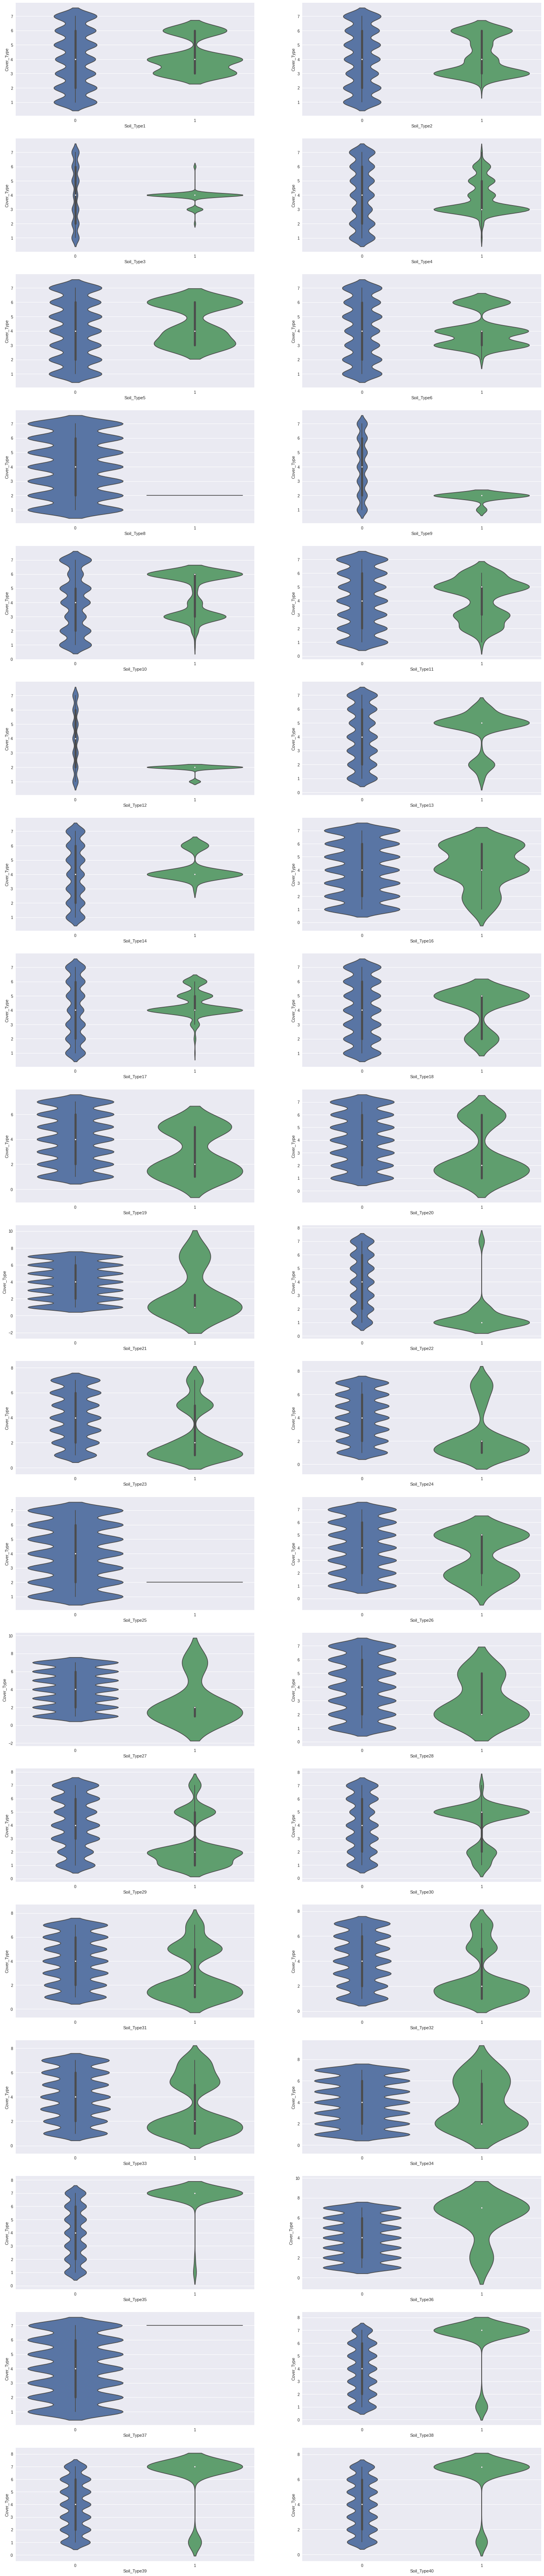

In [17]:
# Visualize the distribution of soil type and "cover type"
st_list = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16','Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']

fig, axes = plt.subplots(19,2,figsize=(24,120))
for i in range(len(st_list)):
    sns.violinplot(y=train_df['Cover_Type'],x=train_df[st_list[i]], ax=axes[i//2,i%2])
plt.show()

Here we can examine the relationship between soil type and cover type for each soil type. # TODO: Discuss more

Now, we'll isolate and explore the distribution of wilderness types. 

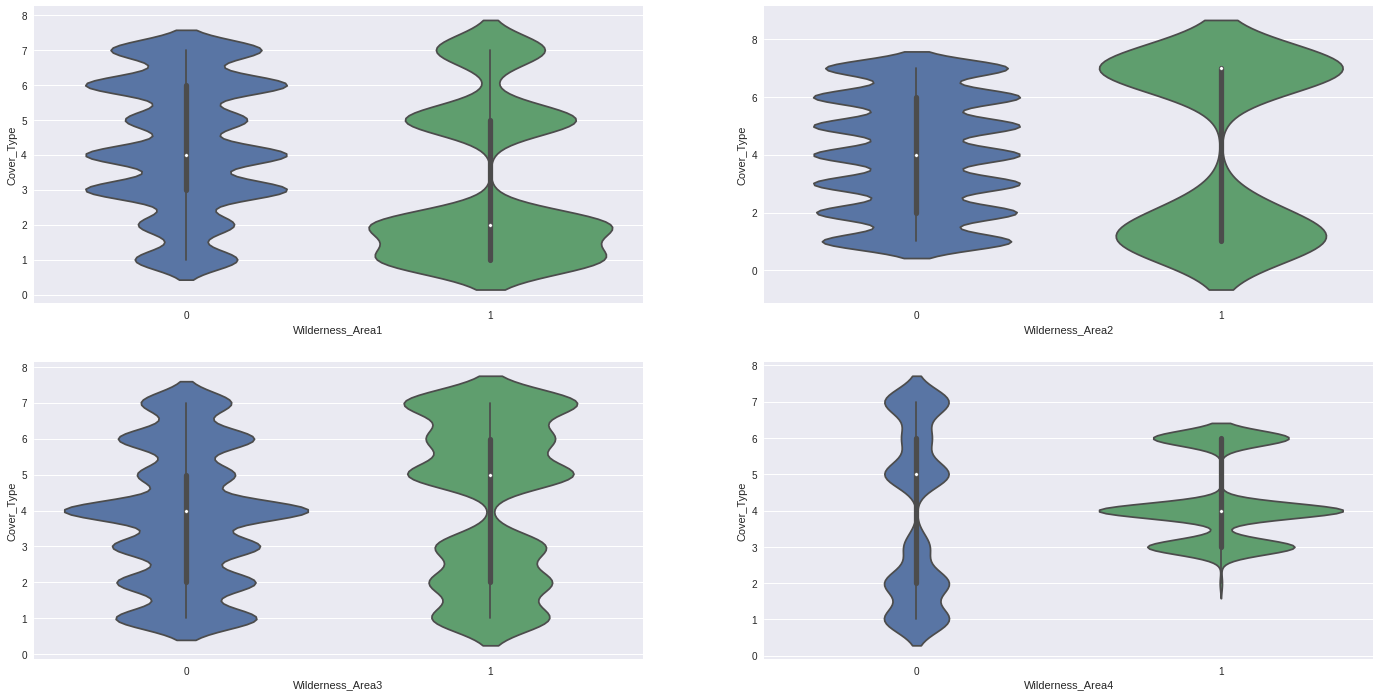

In [18]:
wilderness_list =['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4']

# Visualize the distribution of wilderness area and "cover type"
fig, axes = plt.subplots(2,2,figsize=(24,12))
for i in range(4):
    sns.violinplot(y=train_df['Cover_Type'],x=train_df[wilderness_list[i]], ax=axes[i//2,i%2])
plt.show()

link text### Feature Engineering 1

Now we'll normalize the "Hillsdale" variables by dividing them by 255.

In [19]:
fe1_cols = ['Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm']
train_df[fe1_cols] = train_df[fe1_cols]/255

link text### Feature Engineering 2a
Now we'll create additional features to magnify the differences betweeen cover type1 and 2, and covery type3 and 6.

In [20]:
#create additional features to magnify the differences between cover type 1 and 2
# Combine soil type 2,18,25,3,36,6,8,28,34 and wildness area 4 as only cover type 2 appers under these features
train_df["type2stwa4"] = train_df["Soil_Type6"] + train_df["Wilderness_Area4"] +  \
train_df["Soil_Type2"]+ train_df["Soil_Type18"] +  train_df["Soil_Type25"] +  \
train_df["Soil_Type3"] + train_df["Soil_Type36"]+ \
train_df["Soil_Type8"] + train_df["Soil_Type34"]+ train_df["Soil_Type28"]

# Combine soil type 20, 23, 24, 31, 33 and 34 as only cover type 6 appears under these features but not cover type 3.
train_df["type6st"] = train_df["Soil_Type20"] + train_df["Soil_Type23"]+ \
train_df["Soil_Type24"] +  train_df["Soil_Type31"] + train_df["Soil_Type33"] +  train_df["Soil_Type34"]

[link text](https://)### Feature Engineering 2b

Now we'll drop soil types that don't exist in the training set. Then we will combine soil types 35, 38, 39 and 40 because they have a very similar distribution. 

In [21]:
# Remove soil type 7 and 15 due to no data
train_df.drop(columns=["Soil_Type7", "Soil_Type15"], inplace=True)

# Remove soil type 19, 37, 34, 21, 27,36,28,8,25 due to no limited data - TODO: should we be dropping these? 
train_df.drop(columns=["Soil_Type19", "Soil_Type37","Soil_Type34", "Soil_Type21","Soil_Type27", "Soil_Type36","Soil_Type28","Soil_Type8", "Soil_Type25"], inplace=True)

# Combine soil type 35,38,39, 40
train_df["soil_type35383940"] = train_df["Soil_Type38"] +  train_df["Soil_Type39"] + train_df["Soil_Type40"] +  train_df["Soil_Type35"]
# Combine soil type 10,11, 16, 17
train_df["st10111617"] = train_df["Soil_Type10"] + train_df["Soil_Type11"] + train_df["Soil_Type16"] + train_df["Soil_Type17"]
#combine soil type 9, 12
train_df["st912"] = train_df["Soil_Type9"] + train_df["Soil_Type12"] 
#combine soil type 31,33
train_df["st3133"] = train_df["Soil_Type31"] + train_df["Soil_Type33"]
#combine soil type 23, 24
train_df["st2324"] = train_df["Soil_Type23"] + train_df["Soil_Type24"]
#combine soil type 6 and wilderness area 4
train_df["st6w4"] = train_df["Soil_Type6"] + train_df["Wilderness_Area4"]

train_df.drop(columns=["Soil_Type35","Soil_Type38", "Soil_Type39",'Soil_Type40','Soil_Type10','Soil_Type11','Soil_Type16','Soil_Type17','Soil_Type9','Soil_Type12','Soil_Type31','Soil_Type33','Soil_Type23','Soil_Type24','Soil_Type6','Wilderness_Area4'], inplace=True)

              
# Check shape is as expected
print(train_df.shape)


(15120, 37)


[link text](https://)### Feature Engineering 3

Now we'll transform the Asepct feature.

In [22]:
#convert aspect into sine and cosine values 
train_df["ap_ew"] = np.sin(train_df["Aspect"]/180*np.pi)
train_df["ap_ns"] = np.cos(train_df["Aspect"]/180*np.pi)

#drop Aspect column
train_df.drop(columns= ["Aspect"], inplace=True)
              
# Check shape is as expected
print(train_df.shape)

(15120, 38)


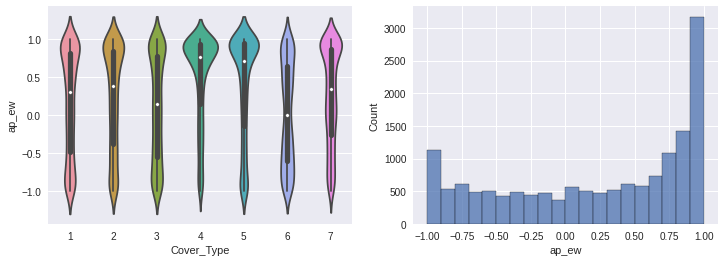

In [23]:
#visualize cover type VS the cosine of Aspect degerees
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
sns.violinplot(x=train_df['Cover_Type'],y=train_df['ap_ew'],ax=ax1)
sns.histplot(train_df['ap_ew'],ax=ax2)
plt.show()


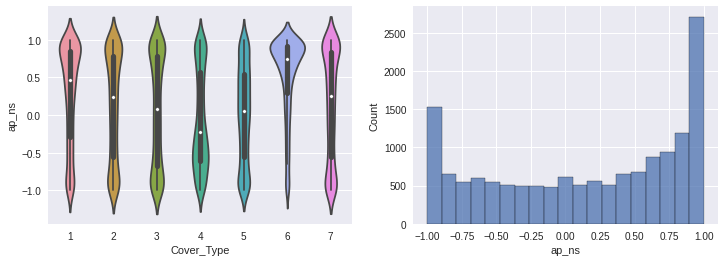

In [24]:
#visualize cover type VS the sine of Aspect degerees
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
sns.violinplot(x=train_df['Cover_Type'],y=train_df['ap_ns'],ax=ax1)
sns.histplot(train_df['ap_ns'],ax=ax2)
plt.show()


After the feature transformation, we see improved distinction in median values, espeically for cover type 6, where the median is notably higher than that of other cover types  and the distribution is concentrated around the median. 

[link text](https://)### Feature Engineering 4

Now we'll log transform the features related to the distances.

In [25]:
#complie a list of features to perform log transformation
fe4_cols = ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points']

In [26]:
#check the minimum value 
train_df['Vertical_Distance_To_Hydrology'].min()

-146

In [27]:
#add 147 to ensure no negative or 0 in the values 
train_df[fe4_cols] = train_df[fe4_cols] + 147

In [28]:
#log transform
train_df[fe4_cols] = np.log(train_df[fe4_cols])

In [29]:
#make a copy of train_df for modelling
train_df1 = train_df.copy()
#drop Id column as it is not a meaningful feature.
train_df1.drop(columns=["Id"],inplace=True)
test_df.drop(columns=["Id"],inplace=True)

In [30]:
train_df1.columns

Index(['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Soil_Type1', 'Soil_Type2',
       'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type18', 'Soil_Type20', 'Soil_Type22', 'Soil_Type26',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type32', 'Cover_Type', 'type2stwa4',
       'type6st', 'soil_type35383940', 'st10111617', 'st912', 'st3133',
       'st2324', 'st6w4', 'ap_ew', 'ap_ns'],
      dtype='object')

In [31]:
new_cat_cols =['Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Soil_Type1', 'Soil_Type2',
       'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type18', 'Soil_Type20', 'Soil_Type22', 'Soil_Type26',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type32', 'Cover_Type', 'type2stwa4',
       'type6st', 'soil_type35383940', 'st10111617', 'st912', 'st3133',
       'st2324', 'st6w4']

In [32]:
#change data type to categorical for categorical columns
train_df1[new_cat_cols] = train_df1[new_cat_cols].astype("category")

In [33]:
# get NA values

print("There are {} NA values in the training data".format(train_df1.isna().sum().sum()))
print("There are {} NA values in the test data".format(train_df1.isna().sum().sum()))
    # `.isna()` returns a df with bools the first `.sum()` returns series, second is int 
print()
print("There are {} values in the training data".format(train_df1.count()[0]))
print("There are {} values in the test data".format(test_df.count()[0]))

There are 0 NA values in the training data
There are 0 NA values in the test data

There are 15120 values in the training data
There are 565892 values in the test data


### Additional Data Mungling

Then, we split the training data into a training data set (80%) and development data set (20%). We will also have a large, separate test data set. 

In [34]:
# Split training data (labeled) into 80% training and 20% dev) and randomly sample 
training_data = train_df1.sample(frac=0.8)
dev_data_df = train_df1.drop(training_data.index)

# Examine shape of both data sets
print(training_data.shape)
print(dev_data_df.shape)

# Briefly examine feature attributes for the training data 
training_data.describe()

(12096, 37)
(3024, 37)


,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,ap_ew,ap_ns
count,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000
mean,2750.814319,16.540427,5.789199,5.247670,7.276136,0.834807,0.858442,0.528551,7.210855,0.228618,0.145528
std,418.351305,8.477338,0.518797,0.283872,0.731755,0.119183,0.089722,0.180076,0.650228,0.675448,0.685859
min,1874.000000,0.000000,4.990433,0.000000,4.990433,0.227451,0.388235,0.000000,4.990433,-1.000000,-1.000000
25%,2376.000000,10.000000,5.365976,5.023881,6.815640,0.768627,0.811765,0.415686,6.776507,-0.374607,-0.500000
50%,2753.000000,15.000000,5.789960,5.192957,7.282417,0.862745,0.870588,0.541176,7.244942,0.406737,0.258819
75%,3106.000000,22.000000,6.167516,5.424950,7.788626,0.921569,0.921569,0.654902,7.664347,0.866025,0.809017
max,3849.000000,50.000000,7.289611,6.552508,8.858937,0.996078,0.996078,0.972549,8.873468,1.000000,1.000000


Additionally, we will scale the training data to have a mean of 0 and a variance of 1. Then we will retrieve the original training mean and variance for each feature and use that to standardize the development data.

In [35]:
# Split into data and labels
train_data = training_data.drop(columns=["Cover_Type"])
train_labels = training_data["Cover_Type"]
dev_data = dev_data_df.drop(columns=["Cover_Type"])
dev_labels = dev_data_df["Cover_Type"]
test_data = test_df

# Double check the shape
print(train_data.shape)
print(dev_data.shape)

(12096, 36)
(3024, 36)


In [36]:
train_data.columns

Index(['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Soil_Type1', 'Soil_Type2',
       'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type18', 'Soil_Type20', 'Soil_Type22', 'Soil_Type26',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type32', 'type2stwa4', 'type6st',
       'soil_type35383940', 'st10111617', 'st912', 'st3133', 'st2324', 'st6w4',
       'ap_ew', 'ap_ns'],
      dtype='object')

In [37]:
#compile a list for columns for scaling
ss_cols = ['Elevation','Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points']

In [38]:
# Normalize features using the standard scaler [training data]

def scaler(ss="",cols=ss_cols):
  if ss == "minmax":
    scaler = MinMaxScaler()
  else :
    scaler = StandardScaler()
  model = scaler.fit(train_data[cols])
  train_data[cols] = model.transform(train_data[cols])
  print(train_data.shape)
  # Normalize features using the standard scaler [dev data]
  dev_data[cols] = model.transform(dev_data[cols])

scaler()

(12096, 36)


In [39]:
# Double check shape
print(train_data.shape, dev_data.shape)

(12096, 36) (3024, 36)


In [40]:
# Explore and confirm the shape of the data
print("Training data shape: {0} Training labels shape: {1}".format(train_data.shape, train_labels.shape))
print("Dev data shape: {0} Dev labels shape: {1}".format(dev_data.shape, dev_data.shape))
print("Test data shape: ", test_data.shape)

Training data shape: (12096, 36) Training labels shape: (12096,)
Dev data shape: (3024, 36) Dev labels shape: (3024, 36)
Test data shape:  (565892, 54)


In [41]:
# Examine Training Data 
dev_data.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type13,Soil_Type14,Soil_Type18,Soil_Type20,Soil_Type22,Soil_Type26,Soil_Type29,Soil_Type30,Soil_Type32,type2stwa4,type6st,soil_type35383940,st10111617,st912,st3133,st2324,st6w4,ap_ew,ap_ns
11,0.323152,-0.653584,0.888200,-0.332481,1.801247,0.917647,0.941176,0.533333,1.740243,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.484810,-0.874620
18,-0.589993,-1.479349,-0.578787,-0.788377,-0.744977,0.839216,0.909804,0.611765,2.215767,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000,1.000000
24,-0.582822,-0.889517,-0.389282,-0.585729,-0.679697,0.843137,0.866667,0.560784,2.205513,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.374607,0.927184
28,0.143870,-1.833249,0.181434,-0.251955,1.327116,0.862745,0.933333,0.603922,2.234743,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.707107,-0.707107
34,-0.563699,-0.889517,-0.107671,-0.811630,-0.763035,0.866667,0.862745,0.521569,2.204972,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.656059,0.754710


In [42]:
all_features = set(train_data.columns.to_list())

In [43]:
#select features to drop. 
to_drop = set(['Hillshade_9am'])


In [44]:
sel_features = list(all_features - to_drop)

In [45]:
dev_data = dev_data[sel_features]
train_data =train_data[sel_features]


In [46]:
# Explore and confirm the shape of the data
print("Training data shape: {0} Training labels shape: {1}".format(train_data.shape, train_labels.shape))
print("Dev data shape: {0} Dev labels shape: {1}".format(dev_data.shape, dev_data.shape))
# print("Test data shape: ", test_data.shape)

Training data shape: (12096, 35) Training labels shape: (12096,)
Dev data shape: (3024, 35) Dev labels shape: (3024, 35)


In [47]:
# get NA values
train_data.head(20)

,Wilderness_Area1,st3133,ap_ew,type2stwa4,st2324,Soil_Type30,st6w4,Soil_Type20,Hillshade_Noon,Soil_Type32,type6st,st912,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology,Soil_Type2,Soil_Type29,Elevation,ap_ns,Soil_Type5,Horizontal_Distance_To_Roadways,Soil_Type14,Horizontal_Distance_To_Fire_Points,Soil_Type18,Soil_Type1,Soil_Type4,Soil_Type13,Soil_Type22,Wilderness_Area3,Wilderness_Area2,soil_type35383940,Soil_Type3,Soil_Type26,Slope,st10111617,Hillshade_3pm
5640,0,0,0.945519,1,0,0,1,0,0.854902,0,0,0,-0.906209,-1.539713,0,0,-1.189992,-0.325568,0,-1.308098,0,-0.721553,0,1,0,0,0,0,0,0,0,0,0.054214,0,0.364706
10110,0,0,0.819152,0,0,0,0,0,0.776471,0,0,0,0.701287,0.846825,0,0,1.652234,-0.573576,0,0.787063,0,-0.346375,0,0,0,0,0,1,0,1,0,0,1.823711,0,0.180392
12414,0,0,0.681998,2,0,0,2,0,0.792157,0,0,0,0.107253,-0.660133,0,0,-1.656127,-0.731354,0,-1.512215,0,-1.507801,0,0,0,0,0,0,0,0,0,0,2.177610,0,0.196078
942,1,0,0.034899,0,0,0,0,0,0.807843,0,0,0,-0.173228,0.729251,0,1,0.521559,0.999391,0,1.764309,0,0.595266,0,0,0,0,0,0,0,0,0,0,0.054214,0,0.576471
10831,0,0,0.484810,1,0,0,0,0,0.905882,0,0,0,-1.053016,-1.181722,0,0,-0.544575,-0.874620,0,0.069681,0,-0.601105,0,0,0,0,0,1,0,0,1,0,0.879979,0,0.411765
6613,0,0,0.996195,0,0,0,0,0,0.815686,0,0,0,0.195995,0.296083,0,0,1.171757,-0.087156,0,-0.456428,0,-0.377998,0,0,0,0,0,1,0,1,0,0,0.290147,0,0.321569
13349,0,0,-0.629320,1,0,0,1,0,0.815686,0,0,0,0.950407,0.296083,0,0,-0.766886,0.777146,0,-0.695334,0,0.051326,0,0,0,0,0,0,0,0,0,0,0.997946,1,0.760784
13419,0,0,0.034899,1,0,0,1,0,0.764706,0,0,0,-0.651991,-1.181722,0,0,-0.855332,0.999391,0,-0.018460,0,-0.574472,0,0,0,0,0,0,0,0,0,0,0.526080,1,0.556863
3114,0,0,-0.342020,1,0,0,1,0,0.992157,0,0,0,-0.742326,-1.181722,0,0,-1.512701,-0.939693,0,-0.913096,0,-1.174328,0,0,1,0,0,0,0,0,0,0,0.762013,0,0.674510
3407,0,0,-0.034899,1,0,0,1,0,0.686275,0,0,0,1.571414,0.865742,0,0,-1.060909,0.999391,0,-0.689057,0,-0.584405,0,0,0,0,0,0,0,0,0,0,1.469812,1,0.545098


## Models
#### Random Forest

Random Forest Performance for 1 trees: 0.5439814814814815
Random Forest Performance for 3 trees: 0.7053571428571429
Random Forest Performance for 5 trees: 0.7139550264550265
Random Forest Performance for 10 trees: 0.7473544973544973
Random Forest Performance for 100 trees: 0.7685185185185185
Random Forest Performance for 300 trees: 0.7718253968253969


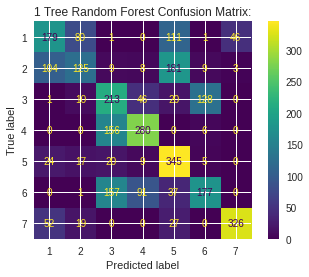

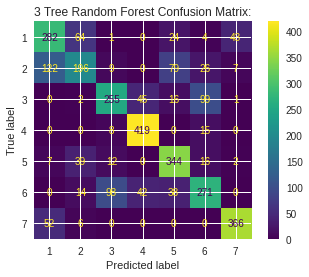

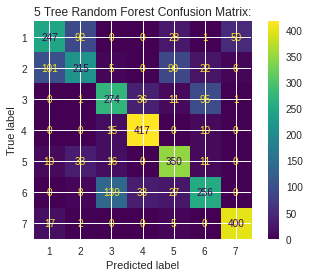

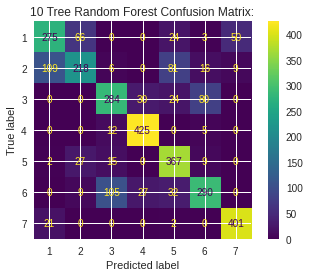

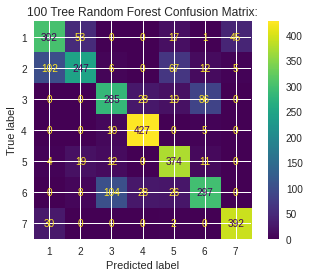

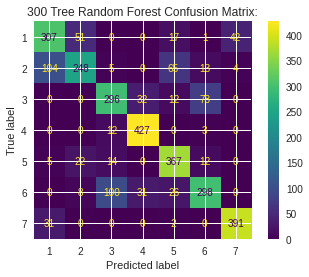

In [48]:
# Try a random forest
def RandomForest(num_trees):
    model = RandomForestClassifier(num_trees,max_depth=8)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("Random Forest Performance for {0} trees: {1}".format(num_trees,score))
    # Plot_confusion_matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("{} Tree Random Forest Confusion Matrix:".format(num_trees))
    plt.plot()
    
num_trees_list = [1,3,5,10,100,300]
for num_trees in num_trees_list:
    RandomForest(num_trees)

#### Naive Bayes (Bernoulli)

BernoulliNB for alph = 0.01: accuracy = 0.5952380952380952





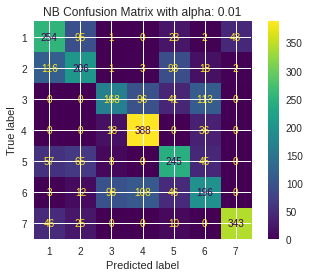

In [49]:
# Try Naive Bayes - Bernoulli 
def NB(alf):
    model = BernoulliNB(alpha = alf)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("BernoulliNB for alph = {0}: accuracy = {1}".format(alf,score))
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("NB Confusion Matrix with alpha: {}".format(alf))
    plt.plot()
    print('\n\n')
    
# the alpha isn't actually making a difference 
# alphas_list = [0.00001,0.001, 0.01, 0.1, 1, 10]
alphas_list = [0.01]
for alpha in alphas_list:
    NB(alpha)

In [50]:
# Try Naive Bayes - multi-nominal
# def MNB(alf):
#     model = MultinomialNB(alpha = alf)
#     model.fit(train_data, train_labels)
#     predictions = model.predict(dev_data)
#     score = model.score(dev_data, dev_labels)
#     print("Multi NB for alph = {0}: accuracy = {1}".format(alf,score))
#     # Plot Confusion Matrix
#     plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
#     plt.title("Multi NB Confusion Matrix with alpha: {}".format(alf))
#     plt.plot()
#     print('\n\n')
    
# the alpha isn't actually making a difference 
# alphas_list = [0.00001,0.001, 0.01, 0.1, 1, 10]
# alphas_list = [1.0]
# for alpha in alphas_list:
#     MNB(alpha)

#### K-Nearest Neighbors

KNN 1 neighbors : accuracy = 0.8356481481481481
KNN 2 neighbors : accuracy = 0.8012566137566137
KNN 4 neighbors : accuracy = 0.8095238095238095
KNN 7 neighbors : accuracy = 0.8039021164021164
KNN 10 neighbors : accuracy = 0.7847222222222222


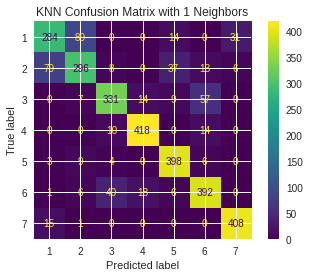

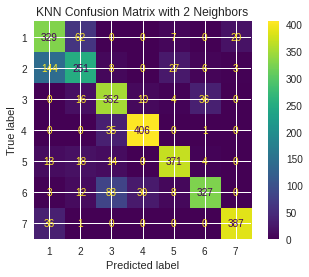

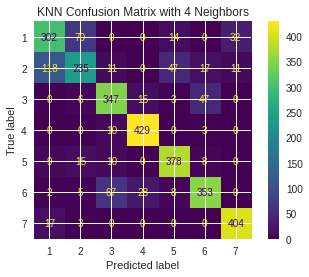

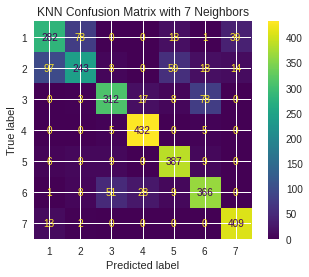

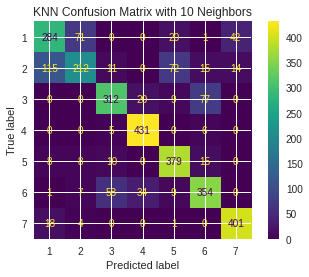

In [51]:
# Try K Nearest Neighbors
def KNN(kn):
    model = KNeighborsClassifier(n_neighbors = kn)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("KNN {0} neighbors : accuracy = {1}".format(kn,score))
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("KNN Confusion Matrix with {} Neighbors".format(kn))
    plt.plot()
    
# The alpha isn't actually making a difference 
neigh_list = [1,2,4, 7, 10]
for neigh in neigh_list:
    KNN(neigh)

#### Multi-layer Perceptron

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP accuracy =  0.8505291005291006


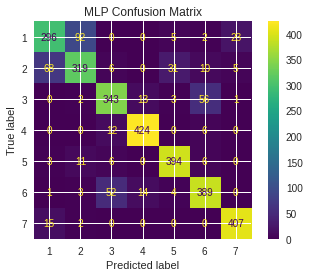

In [52]:
# Try Multi-Layer Perceptron
def MLP():
#    model = MLPClassifier(solver='adam', alpha=1e-6, hidden_layer_sizes=(100, ), random_state=0) .8257
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0)  .82969
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(200, ), random_state=0) .837
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0, activation='tanh') .83068

    # Default activation is 'relu', random state lets us get the same result every time (so we can tune other parameters)
    # max_iter is 200 by default, but more helps. alpha is the regularization parameter. solver is 'adam' by default
    model = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(200,), random_state=0, max_iter=300) 
    model.fit(train_data, train_labels) 
    score = model.score(dev_data, dev_labels)
    print("MLP accuracy = ",score)
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("MLP Confusion Matrix")
    plt.plot()

    
MLP()

In [53]:
#logistic regression
def LR():
  model = LogisticRegression(random_state=0, multi_class='ovr',solver='lbfgs', max_iter = 300)
  model.fit(train_data, train_labels)
  score = model.score(dev_data,dev_labels)
  print("Logistic Regression accuracy = ",score)
LR()

Logistic Regression accuracy =  0.6693121693121693


### End matter

#### Acknowledgements/Sources

* That helpful stack overflow post
  * the url for it
* Relevant Documentation
  * KNeighborsClassifier
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  * Pretty Confusion Matrix
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  * Preprocessing
    * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
* Soil information
  * https://www.uidaho.edu/cals/soil-orders/aridisols
  
#### Backup Formats

*because sometimes you just want to look at the markdown or whatever real quick*

In [54]:
#Create a backup of the jupyter notebook in a format for where changes are easier to see.
!jupyter nbconvert clear-cut-solution.ipynb --to="python" --output="backups/clear-cut-solution"
!jupyter nbconvert clear-cut-solution.ipynb --to markdown --output="backups/clear-cut-solution"

# Also archiving this bad boy
!jupyter nbconvert clear-cut-solution.ipynb --to html --output="backups/clear-cut-solution"

[NbConvertApp] WARNING | pattern u'clear-cut-solution.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
  